In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=mnist_transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.65MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import random_split

In [5]:
# Define split ratios
train_size = int(0.8 * len(mnist_train))
val_size = int(0.2 * len(mnist_train))

# Split dataset
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

pred_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
class Generator(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Flatten(),
            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 28*28)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
generator = Generator(dropout_prob=0.3)

In [11]:
class Adversial(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Flatten(),
            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(1200, 1)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
adv = Adversial(dropout_prob=0.3)

In [13]:
num_batches = len(train_loader)
num_batches

1500

In [14]:
import itertools

In [15]:
import torch.nn.functional as F

def adversarialLoss(d_x, d_g_z):
    return (F.binary_cross_entropy_with_logits(d_x, torch.ones_like(d_x)) +
            F.binary_cross_entropy_with_logits(d_g_z, torch.zeros_like(d_g_z)))

def generatorLoss(d_g_z):
    return F.binary_cross_entropy_with_logits(d_g_z, torch.ones_like(d_g_z))

In [16]:
import math

In [17]:
learning_rate = 1e-3
weight_decay = 1e-4
k = 1

# less epoch as can easily overfit
num_epoch = 20000

lossi_gen = []
lossi_adv = []

total_samples = len(train_loader)

advOptimizer = torch.optim.AdamW(adv.parameters(), lr=learning_rate, weight_decay=weight_decay)
generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=learning_rate, weight_decay=weight_decay)

generator = generator.to(device)
adv = adv.to(device)

train_loader_iter_adv_training = itertools.cycle(iter(train_loader))

for epoch in range(num_epoch):
    adv.train()
    generator.eval()
    
    for _ in range(k):
        advOptimizer.zero_grad()
        
        feature, _ = next(train_loader_iter_adv_training)
        feature = feature.to(device)
        # print(f"feature: {feature}")
        # print(f"feature.shape: {feature.shape}")

        pred_data = adv(feature)
        # print(f"pred_data: {pred_data}")
        # print(f"pred_data.shape: {pred_data.shape}")

        noise = torch.randn(batch_size, 1, 28, 28)
        noise = noise.to(device)
        # print(f"noise: {noise}")
        # print(f"noise.shape: {noise.shape}")
    
        gen_data = generator(noise)
        # print(f"gen_data: {noise}")
        # print(f"gen_data.shape: {gen_data.shape}")
        
        pred_gen_data = adv(gen_data)
        # print(f"pred_gen_data: {pred_gen_data}")
        # print(f"pred_gen_data.shape: {pred_gen_data.shape}")

        # loss
        advLoss = adversarialLoss(pred_data, pred_gen_data)

        advLoss.backward()
        advOptimizer.step()

        advLoss = advLoss.log10()
        lossi_adv.append(advLoss.detach().cpu())

    generatorOptimizer.zero_grad()

    adv.eval()
    generator.train()

    noise = torch.randn(batch_size, 1, 28, 28)
    noise = noise.to(device)
    # print(f"noise: {noise}")
    # print(f"noise.shape: {noise.shape}")

    gen_data = generator(noise)
    # print(f"gen_data: {noise}")
    # print(f"gen_data.shape: {gen_data.shape}")

    pred_gen_data = adv(gen_data)
    # print(f"pred_gen_data: {pred_gen_data}")
    # print(f"pred_gen_data.shape: {pred_gen_data.shape}")
    
    # loss
    genLoss = generatorLoss(pred_gen_data)

    genLoss.backward()
    generatorOptimizer.step()

    genLoss = genLoss.log10()
    lossi_gen.append(genLoss.detach().cpu())

    if ((epoch+1)%1000==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Adversial Loss: {advLoss.item():.4f}, Generator Loss: {genLoss.item():.4f}")

Epoch 1000/20000, Adversial Loss: 0.0023, Generator Loss: 0.9662
Epoch 2000/20000, Adversial Loss: 0.1436, Generator Loss: 0.9087
Epoch 3000/20000, Adversial Loss: -0.6325, Generator Loss: 0.4689
Epoch 4000/20000, Adversial Loss: -0.0819, Generator Loss: 0.5065
Epoch 5000/20000, Adversial Loss: -1.2840, Generator Loss: 0.8392
Epoch 6000/20000, Adversial Loss: -0.3433, Generator Loss: 0.7057
Epoch 7000/20000, Adversial Loss: -0.6957, Generator Loss: 0.9513
Epoch 8000/20000, Adversial Loss: -0.9036, Generator Loss: 0.8856
Epoch 9000/20000, Adversial Loss: -2.5119, Generator Loss: 0.8426
Epoch 10000/20000, Adversial Loss: -0.5361, Generator Loss: 0.8539
Epoch 11000/20000, Adversial Loss: -1.4345, Generator Loss: 0.9882
Epoch 12000/20000, Adversial Loss: -0.7789, Generator Loss: 1.0994
Epoch 13000/20000, Adversial Loss: -1.6739, Generator Loss: 0.7032
Epoch 14000/20000, Adversial Loss: -1.9634, Generator Loss: 0.9110
Epoch 15000/20000, Adversial Loss: -2.5334, Generator Loss: 0.9674
Epoch 

In [18]:
import matplotlib.pyplot as plt

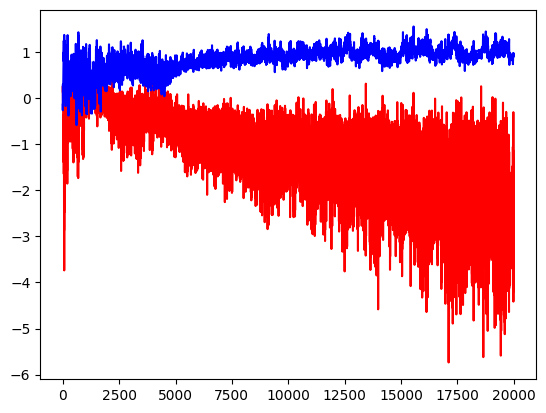

In [19]:
plt.plot(lossi_adv, c="red")
plt.plot(lossi_gen, c="blue")

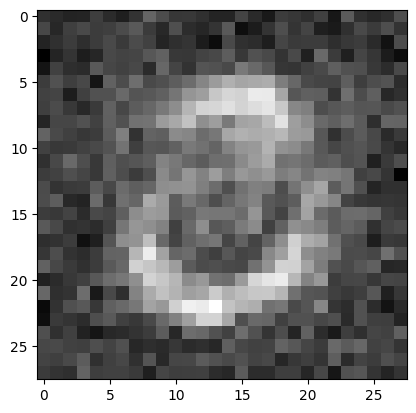

In [20]:
generator.eval()

with torch.no_grad():
    noise = torch.randn(1, 1, 28, 28)
    noise = noise.to(device)
    
    gen_img = generator(noise)
    img = gen_img.view(1, 28, 28)
    
    plt.imshow(img.squeeze().cpu(), cmap="gray")
    plt.show()